<a href="https://colab.research.google.com/github/iremakalp/Plant_Disease_Detection/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Import CNN Libraries**



In [1]:
import os 
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pltpi
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

#### **Test-Train Data**
**Split the dataset**

In [33]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="/Final_Datasets/CNN_Dataset"
test_dir="/NewCNN/test"

In [14]:
 #train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*")) 
#test file image count
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

25 Classes
30247 Train images
0 Test images


#### **Image Augumentation**

**ImageDataGenerator**,Data augmentation is used to increase the size of training set and to get more different image. Through Data augmentation we can prevent overfitting ,this refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating
* **Rescale:** One of the many magnification parameters adjusts the pixel values of our image.
* **Shear_range:** counterclockwise shear angle in degrees
* **Zoom_range:** zoom
* **Horizontal_flip:** flip image horizontally

> Do not perform augmentation on validation and test data/validation set ,this might mislead the results


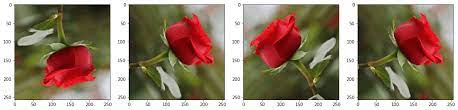

In [15]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)

**flow_from_directory() -->** Another method to read images into TensorFlow environment is to use the .flow_from_directory() method. flow_from_directory is an ImageDataGenerator method. The dataset is read with flow_from_directory without making any changes.

**Parameters:**
* **directory:** The path of the target directory. It must contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF formatted images found in each of the subdirectories will be included in the generator.
* **target_size:** A tuple of integers, (height, width), by default (256,256). All found images will be resized.
* **batch_size:** The size of the data chunks (default: 32).
* **shuffle:** Decides whether to shuffle data (default: True). If set to false, it sorts the data in alphanumeric order.



In [16]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 30247 images belonging to 25 classes.
Found 0 images belonging to 0 classes.


#### **CNN Implementation**

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

In [17]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu',name="conv2d_1"))
model.add(MaxPooling2D(pool_size=(3, 3),name="max_pooling2d_1"))
model.add(Conv2D(32, (3, 3),activation='relu',name="conv2d_2"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_2"))
model.add(Conv2D(64, (3, 3),activation='relu',name="conv2d_3"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_3"))   
model.add(Flatten(name="flatten_1"))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0

In [18]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 0 images belonging to 0 classes.


When compiling the model, we provide **objective function (loss)**, **optimization method (adam)** and **accuracy** that we will follow.

For training, the 'fit()' function is used in the model with the following parameter:
* **train:** training data,
* **validation_data:** validation set,
* **shuffle:** change of location of data in each epoch,
* **verbose:** to be able to see the outputs during the training (0-> does not show, 1-> does)
* **epoch:** determines how many times the dataset will be trained by traversing the model
* **callbacks:** An object that can perform actions at various stages of training (for example, at the beginning or end of a period, before or after a single batch, etc.).

**ReduceLROnPlateau():** Models benefit from reducing the learning rate by 2-10 times when learning becomes sluggish. If it checks and no improvement is seen for the 'patience' count, the learning rate drops.
* **monitor**: value to monitor
* **factor:** factor by which the learning rate will be reduced
* **patience: the number of non-development periods after which the learning rate will decrease
* **min_lr:** lower limit of learning rate


In [19]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
history1 = model.fit(
    train_generator,#egitim verileri
    steps_per_epoch=None,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True
    )

Epoch 1/2
946/946 [==============================] - 544s 574ms/step - loss: 1.1014 - accuracy: 0.6635 - lr: 0.0010
Epoch 2/2
946/946 [==============================] - 560s 591ms/step - loss: 0.5037 - accuracy: 0.8378 - lr: 0.0010


In [21]:
model.save('/NewCNN/plant_disease_Cnn.h5')

#### **CNN Testing**

In [51]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
model_cnn=load_model('/NewCNN/plant_disease_Cnn.h5')

Apple_scab.jpg
1/1 [==============================] - 0s 44ms/step
Apple___Apple_scab
corn_leaf_spot.jpg
1/1 [==============================] - 0s 23ms/step
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
early_potato.JPG
1/1 [==============================] - 0s 25ms/step
Potato___Early_blight
healthy_apple.JPG
1/1 [==============================] - 0s 26ms/step
Apple___healthy
healthy_peach.JPG
1/1 [==============================] - 0s 21ms/step
Peach___healthy


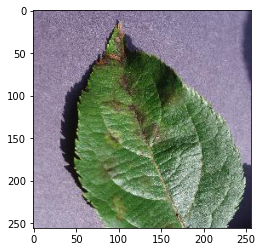

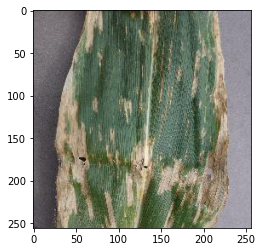

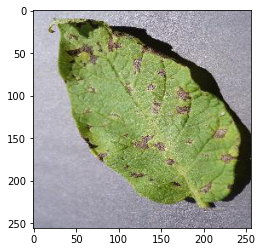

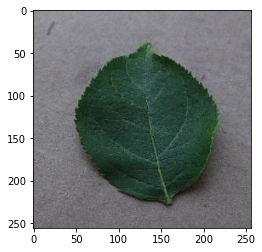

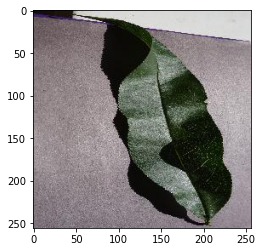

In [61]:

# Pre-Processing test data same as train data. Image augumentation.
def prepare(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224,224))
    x = tf.keras.utils.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

#Loop to iterate over images in testing.
for test_file in os.listdir(test_dir):
    print(test_file)
    classes=list(train_generator.class_indices.keys())
    img_url= test_dir + '/' + test_file
    result_cnn = model_cnn.predict([prepare(img_url)]) #Passes through the model after preparing the image.
    disease = mpimg.imread(img_url)
    plt.figure()
    plt.imshow(disease) #present images as figure

    classresult=np.argmax(result_cnn,axis=1)
    print(classes[classresult[0]])